In [1]:
import sys
sys.path.append("..")

import tangles
import cost_functions
import cut_finding
import importlib
import time

from sklearn.cluster import KMeans
import sklearn.metrics
import pandas as pd

import numpy as np
import random

from collections import Counter

import sklearn.metrics
import tqdm
import importlib
import time
import cut_finding
import plotting
import dataset_generation


def reload():
    importlib.reload(tangles)
    importlib.reload(cost_functions)
    importlib.reload(cut_finding)
    importlib.reload(tangles)
    importlib.reload(plotting)
    importlib.reload(dataset_generation)


In [66]:
from functools import partial
reload()

runs = 10


seed_start = random.randint(0, 1000)
seeds = range(seed_start, seed_start + runs)

k=30

axis_parallel_cut_function = partial(cut_finding.axis_parallel_cuts, k=k)
results = []
n_clusters = 4

for data_size in [60, 600, 6000]:
    print(f"Data size: {data_size}")
    for i in tqdm.tqdm(range(runs)):

        np.random.seed(seeds[i])

        data, labels = dataset_generation.create_2d_test_data(
            means=10*np.random.random(size=(n_clusters, 2)),
            scales=np.random.choice([0.5, 2, 1], size=(n_clusters, 2)),
            weights=np.ones(n_clusters),
            num_samples=data_size,
            min_distance=3
        )

        agreement_param = (min(Counter(labels).values()) * (2/3)) / len(labels)
        models = {
            "TanglesAxisParalleln2": partial(tangles.TangleClustering,
                                        cost_class=cost_functions.SimilarityMatrix,
                                        cut_function=axis_parallel_cut_function,
                                        agreement_param=agreement_param),
            "TanglesAxisParalleln2Optim": partial(tangles.TangleClustering,
                                        cost_class=optimized_cost,
                                        cut_function=axis_parallel_cut_function,
                                        agreement_param=agreement_param),
            "TanglesAxisParallelDist": partial(tangles.TangleClustering,
                                        cost_class=cost_functions.DistanceToOtherSide,
                                        cut_function=axis_parallel_cut_function,
                                        agreement_param=agreement_param),
            "KMeans": KMeans,
        }

        for model_name, Model in models.items():
            starttime = time.time()
            model = Model(n_clusters=n_clusters)
            preds = model.fit_predict(data)

            time_ = time.time() - starttime
            nmi = sklearn.metrics.normalized_mutual_info_score(labels, preds)
            results.append([ model_name,  n_clusters, data_size, nmi, seeds[i], time_])


Data size: 60


100%|██████████| 10/10 [00:00<00:00, 16.30it/s]


Data size: 600


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Data size: 6000


100%|██████████| 10/10 [00:55<00:00,  5.57s/it]


<Figure size 1000x600 with 0 Axes>

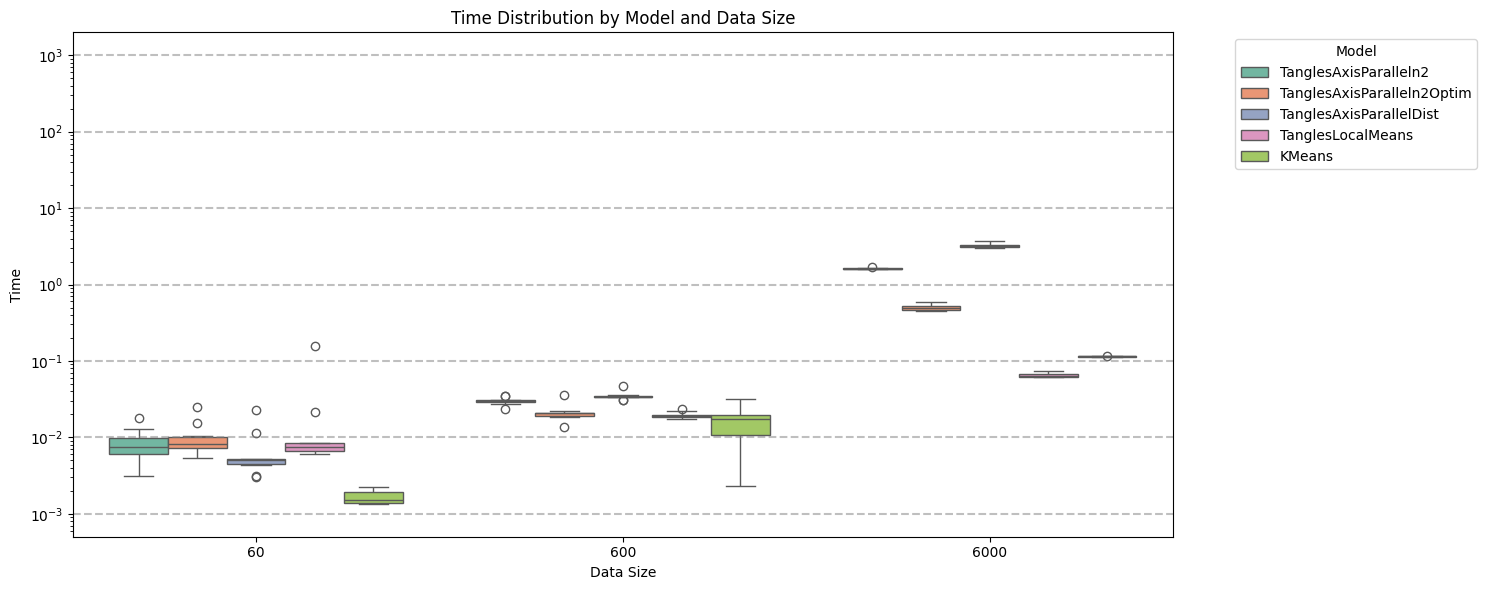

In [67]:

df = pd.DataFrame(results, columns=["Model", "Clusters", "Data-Size", "NMI", "Seed", "Time"])
plotting.BoxPlot(df).time()